## Feature Analysis

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import scipy as sc
import pandas as pd
import operator
import json

pd.options.display.max_columns = None

pd.set_option('compute.use_bottleneck', True)
pd.set_option('compute.use_numexpr', True)

In [16]:
match_id = 60565

with open('../data/general/matches_2017_2018_v1.json') as matches_json:
    matches = json.load(matches_json)

roleassign_df = pd.read_csv('../data/match_{}/role_assignment_count_v2.csv'.format(match_id))
features_df = pd.read_csv('../data/match_{}/features_set.csv'.format(match_id))

## Introduction
In this document, we'll analyze various features obtained from players' $(x,y)$ coordinates and speed $|\vec{V}|$ via visualizations to see which features may be useful for predicting ball locating during the game. 

We need to extract these locations by observing how the features of interest evolves within time; thus we can categorize our aim as a time series analysis task. Furthermore,  if our predictions are to be used in teal time, we should be able to predict them in a time frame of 2-3 seconds after a event occured. 

Some example data with the features we will analyze are as follows:

In [18]:
pd.options.display.float_format = '{:.5f}'.format 
features_df.head(5)

,# refX,refY,refSpeed,refDirectX,refDirectY,homeGoalKeeperX,homeGoalKeeperY,homeGoalKeeperSpeed,homeGoalKeeperDirectX,homeGoalKeeperDirectY,homeLeftBackAvgX,homeLeftBackAvgY,homeLeftBackDenisty,homeLeftBackAvgSpeed,homeLeftBackAvgDirectX,homeCenterBackSlowAvgX,homeCenterBackSlowAvgY,homeCenterBackSlowDenisity,homeCenterBackSlowAvgSpeed,homeCenterBackSlowAvgDirectX,homeCenterBackHirAvgX,homeCenterBackHirAvgY,homeCenterBackHirAvgSpeed,homeCenterBackHirAvgDirectX,homeCenterBackMaxSprintX,homeCenterBackMaxSprintY,homeCenterBackMaxSprintSpeed,homeCenterBackMaxSprintDirectX,homeCenterBackMaxSprintDirectY,homeRightBackAvgX,homeRightBackAvgY,homeRightBackDenisty,homeRightBackAvgSpeed,homeRightBackAvgDirectX,homeLeftWingerAvgX,homeLeftWingerAvgY,homeLeftWingerDenisty,homeLeftWingerAvgSpeed,homeLeftWingerAvgDirectX,homeCenterMiddleSlowAvgX,homeCenterMiddleSlowAvgY,homeCenterMiddleSlowDenisity,homeCenterMiddleSlowAvgSpeed,homeCenterMiddleSlowAvgDirectX,homeCenterMiddleHirAvgX,homeCenterMiddleHirAvgY,homeCenterMiddleHirAvgSpeed,homeCenterMiddleHirAvgDirectX,homeCenterMiddleMaxSprintX,homeCenterMiddleMaxSprintY,homeCenterMiddleMaxSprintSpeed,homeCenterMiddleMaxSprintDirectX,homeCenterMiddleMaxSprintDirectY,homeRightWingerAvgX,homeRightWingerAvgY,homeRightWingerDenisty,homeRightWingerAvgSpeed,homeRightWingerAvgDirectX,homeCenterForwardSlowAvgX,homeCenterForwardSlowAvgY,homeCenterForwardSlowDenisity,homeCenterForwardSlowAvgSpeed,homeCenterForwardSlowAvgDirectX,homeCenterForwardHirAvgX,homeCenterForwardHirAvgY,homeCenterForwardHirAvgSpeed,homeCenterForwardHirAvgDirectX,homeCenterForwardMaxSprintX,homeCenterForwardMaxSprintY,homeCenterForwardMaxSprintSpeed,homeCenterForwardMaxSprintDirectX,homeCenterForwardMaxSprintDirectY,awayGoalKeeperX,awayGoalKeeperY,awayGoalKeeperSpeed,awayGoalKeeperDirectX,awayGoalKeeperDirectY,awayLeftBackAvgX,awayLeftBackAvgY,awayLeftBackDenisty,awayLeftBackAvgSpeed,awayLeftBackAvgDirectX,awayCenterBackSlowAvgX,awayCenterBackSlowAvgY,awayCenterBackSlowDenisity,awayCenterBackSlowAvgSpeed,awayCenterBackSlowAvgDirectX,awayCenterBackHirAvgX,awayCenterBackHirAvgY,awayCenterBackHirAvgSpeed,awayCenterBackHirAvgDirectX,awayCenterBackMaxSprintX,awayCenterBackMaxSprintY,awayCenterBackMaxSprintSpeed,awayCenterBackMaxSprintDirectX,awayCenterBackMaxSprintDirectY,awayRightBackAvgX,awayRightBackAvgY,awayRightBackDenisty,awayRightBackAvgSpeed,awayRightBackAvgDirectX,awayLeftWingerAvgX,awayLeftWingerAvgY,awayLeftWingerDenisty,awayLeftWingerAvgSpeed,awayLeftWingerAvgDirectX,awayCenterMiddleSlowAvgX,awayCenterMiddleSlowAvgY,awayCenterMiddleSlowDenisity,awayCenterMiddleSlowAvgSpeed,awayCenterMiddleSlowAvgDirectX,awayCenterMiddleHirAvgX,awayCenterMiddleHirAvgY,awayCenterMiddleHirAvgSpeed,awayCenterMiddleHirAvgDirectX,awayCenterMiddleMaxSprintX,awayCenterMiddleMaxSprintY,awayCenterMiddleMaxSprintSpeed,awayCenterMiddleMaxSprintDirectX,awayCenterMiddleMaxSprintDirectY,awayRightWingerAvgX,awayRightWingerAvgY,awayRightWingerDenisty,awayRightWingerAvgSpeed,awayRightWingerAvgDirectX,awayCenterForwardSlowAvgX,awayCenterForwardSlowAvgY,awayCenterForwardSlowDenisity,awayCenterForwardSlowAvgSpeed,awayCenterForwardSlowAvgDirectX,awayCenterForwardHirAvgX,awayCenterForwardHirAvgY,awayCenterForwardHirAvgSpeed,awayCenterForwardHirAvgDirectX,awayCenterForwardMaxSprintX,awayCenterForwardMaxSprintY,awayCenterForwardMaxSprintSpeed,awayCenterForwardMaxSprintDirectX,awayCenterForwardMaxSprintDirectY,pitch_index
0,73.38000,38.94000,2.53000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,68.81000,23.42000,1.00000,4.28000,1.00000,53.13000,25.97000,1.00000,1.08000,53.13000,0.00000,0.00000,0.00000,0.00000,75.99000,47.51000,4.92000,1.00000,1.00000,56.58000,53.98000,1.00000,3.29000,1.00000,84.64000,24.69000,1.00000,2.65000,1.00000,88.11000,32.53000,1.00000,1.20000,88.11000,66.56000,39.03000,1.55000,66.56000,0.00000,0.00000,0.00000,0.00000,0.00000,78.73000,51.32000,1.00000,1.14000,1.00000,85.78000,35.11000,1.00000,0.49000,85.78000,0.00000,0.00000,2.55000,0.0000

## Role assignment analysis

Role assignment is one of the most important steps in our project. Our approach is based on the player's role-assignment, rather than using each of their individual data, we groups them based on their roels, then use group features; such as average coordinate and seed of group, fastest player coordinate and seed in the group, for predicting player location. [Here is](scale_roleassign_visualization.ipynb) is more detailed information on how to do arole assignment.

We have folowing roles:

In [30]:
role_dict = {
    0: 'LeftBack',
    1: 'CenterBack',
    2: 'RightBack',
    3: 'LeftWinger',
    4: 'CenterMiddle',
    5: 'RightWinger',
    6: 'CenterForward'
}

Some example data with the role assigment frame we will analyze are as follows:

In [19]:
pd.options.display.float_format = '{:.0f}'.format 
roleassign_df.head(5)

,# matchId,half,min,sec,homeLeftBack,homeCenterBack,homeRightBack,homeLeftWinger,homeCenterMiddle,homeRightWinger,homeCenterForward,awayLeftBack,awayCenterBack,awayRightBack,awayLeftWinger,awayCenterMiddle,awayRightWinger,awayCenterForward
0,60565,1,2,0,1,2,1,1,2,1,2,0,1,1,2,2,2,2
1,60565,1,2,1,1,2,1,1,2,1,2,0,2,0,2,2,2,2
2,60565,1,2,2,1,2,1,1,2,1,2,0,2,0,2,2,2,2
3,60565,1,2,3,1,2,1,1,2,1,2,0,2,0,2,2,2,2
4,60565,1,2,4,1,2,1,1,2,1,2,0,2,0,2,2,2,2


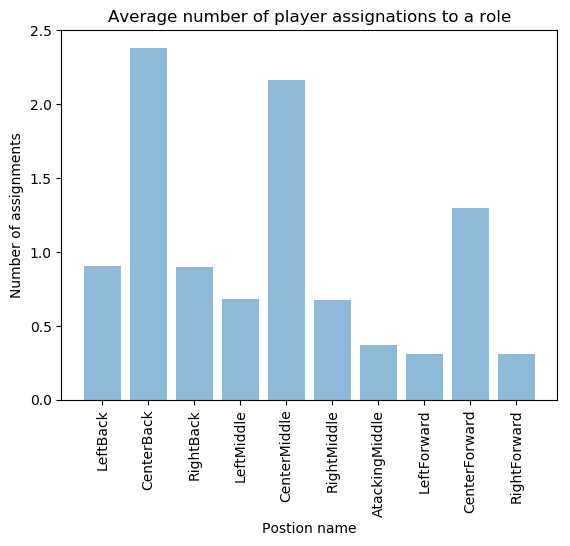

In [36]:
# previous role dictionary
role_dict2 = {
    0: 'LeftBack',
    1: 'CenterBack',
    2: 'RightBack',
    3: 'LeftMiddle',
    4: 'CenterMiddle',
    5: 'RightMiddle',
    6: 'AtackingMiddle',
    7: 'LeftForward',
    8: 'CenterForward',
    9: 'RightForward'
}

def plot_players_assignments(role_dict, source):
    role_rng = len(role_dict)
    role_assignment_count = np.zeros(shape=(role_rng), dtype=np.float)
    match_count = 0

    # reading through the all matches
    for match_data in matches:
        match_id = int(match_data['id'])
        try:
            roleassign_df = pd.read_csv(source.format(match_id))
            for i in range(0,role_rng):
                role_assignment_count[i] += (roleassign_df['home'+ role_dict[i]].sum(axis=0)+ roleassign_df['away'+ role_dict[i]].sum(axis=0))
            match_count+=1
        except FileNotFoundError:
            pass

    for i in range(0,role_rng):
        role_assignment_count[i] = role_assignment_count[i]/(match_count*2*5000)

    label=[]
    for i in range(0,role_rng):
        label.append(role_dict[i])

    y_pos = np.arange(len(label))
    plt.bar(y_pos, role_assignment_count, align='center', alpha=0.5)
    plt.xticks(y_pos, label, rotation='vertical')
    plt.ylabel('Number of assignments')
    plt.xlabel('Postion name')
    plt.title('Average number of player assignations to a role')
    plt.show()
    
plot_players_assignments(role_dict2, source='../data/match_{}/role_assignment_count.csv')

In the above diagram, we can see that Center Back, Center Middle, and Center Forward are the most dominant positions to which players were assigned most. This can be explained with that football matches are generally more concentrated to the center of the pitch. Although Center Forward is among the most assigned position but is only makes about half of the Center Back and Center Middle. We can also categorize Left Back and Right Back as common roles as they are just slightly below Center Forwad, between 2 and 1 assignation to each.<br>
<br>The number of other positions (Left Forward, Right Forward, Atacking Middle) assignation is low compared to 3 major role. That means, their groups features set completely equal to zero most of the time, so that can cause some noise while building a predictive model.

### What can we do about this problem?

#### 1. Combine alike roles together

We can combine less occurred roles together with the most assigned roles of the same category and can me some adjusment on segments borders.
For example, Left Forward and Right Forward are least assigned categories, oppositely the Center Forward is one of the common.<br>
New Combination:
* *Left Back* (0,40,0,19)
* *Center Back* (0,35,19,49)
* *Right Back* (0,40,49,68)
* *Center Middle* (35,75,49,68)
* *Left Middle (+Left Forward)* (40,105,0,19)
* *Center Forward (+Atacking Middle)* (75,105,19,49)
* *Right Middle (+Right Middle)* (40,105,49,68)

From the bar chart shown above, we can easily understand that the number of players assigned to each position during the whole match. Therefore, we can identify specific position which generally occupied by only one player and them reduce the number of extra features calculated for this area.

Average number of player assignations after modification:

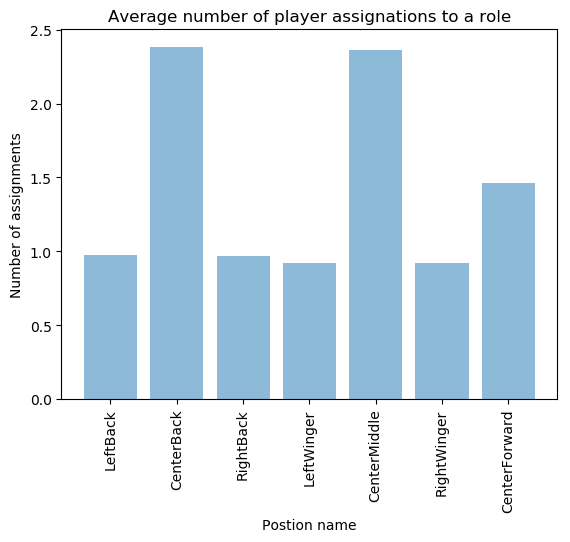

In [37]:
plot_players_assignments(role_dict, source='../data/match_{}/role_assignment_count_v2.csv')

After modification, it seems that on average every position segment has at least 1 player assignation in each distinct frame. Also, the assignation number of side (1) and center (2-3 in general) positions are as we expected. Based on this diagram, while building the features set, our approach to a side position as a single player and to a center as a group featured seems fairly okay.

## Histogram Analysis of Various Features

In this section, we'll plot histograms about some features to generalize the data we have by feature construction.<br>